# Multivariate Time-Series Forecasting: Predict Iron Prices

### Import libs

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

import matplotlib.pyplot as plt
from pylab import rcParams


from sklearn.preprocessing import StandardScaler

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import Adam



In [97]:
def pipeline(filepath_str):
    # import training dataset
    filepath= r'C:\Users\fnafisa\WORKSPACE\professional\Project PoC\Input\data\Construction materials\segregated'+f'\{filepath_str}'
    dataset_train= pd.read_excel(filepath)
    element_name= dataset_train.pop('element_name')[0]
    dataset_train.columns = ['date','price', 'oil_brent', 'tasi', 'gold', 'interest_rate', 'historical']
    dataset_train= dataset_train.sort_values(by=['date'], ascending=True)

    # features selection
    cols= list(dataset_train)[1:-1]

    # Extract dates (timestamp format)
    datelist_train = list(dataset_train['date'])
    
    # dataset_train.index= dataset_train.pop('date')
    print(dataset_train)
    print('Training set shape == {}'.format(dataset_train.shape))
    print('All timestamps == {}'.format(len(datelist_train)))
    print('Featured selected: {}'.format(cols))
    print('Sample of date list: {}...{}'.format(datelist_train[0:2], datelist_train[-3:-1]))
    


    # dataset traing will be the essanse of all the upcoming datasets(training_set, training_set_scaled, X_train, y_train...)
    # make sure there are no commas in any number                                                      "Target"      |--------------------"Predictors"-------------------|
    dataset_train = dataset_train[cols].astype(str) # to remove the date and select only the features : ['price', 'oil_brent', 'tasi', 'gold', 'interest_rate', 'historical']
    for i in cols:
        for j in range(0, len(dataset_train)):
            dataset_train[i][j] = dataset_train[i][j].replace(',', '')

    dataset_train = dataset_train.astype(float)

    # by using multiple predictors (features) we need to convert (reshape) to a matrix(array) using .to_numpy
    training_set= dataset_train.to_numpy()

    # Feature scaling hence features vary in range
    sc = StandardScaler()
    training_set_scaled = sc.fit_transform(training_set)

    sc_predict = StandardScaler()
    target_scaled= sc_predict.fit_transform(training_set[:, 0:1])

    print('Shape of training set        == {}.'.format(training_set.shape))
    print('Shape of training set scaled == {}.'.format(training_set_scaled.shape))

    # Create a data structure with timestamps
    # Target/features selection
    X_train= []
    y_train= []
    n_future= 6 # number of moths to be predicted
    n_past= 12 # the size of the windowed dataframe

    for i in range(n_past, len(training_set_scaled) - n_future +1):
        X_train.append(training_set_scaled[i - n_past:i, 0:dataset_train.shape[1]])
        y_train.append(training_set_scaled[i + n_future - 1:i + n_future, 0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    print('X_train shape == {}.'.format(X_train.shape))
    print('y_train shape == {}.'.format(y_train.shape))



    # Generate list of sequence of months for predictions w datetime type
    datelist_future = pd.date_range(datelist_train[-1], periods=n_future, freq='1m').tolist()
    datelist_future_= []
    for d in datelist_future:
        d= d + dt.timedelta(days=1)
        d= d.date()
        datelist_future_.append(d)
    datelist_future= datelist_future_
    del datelist_future_

    datelist_train_= []
    for this_timestamp in datelist_train:
        datelist_train_.append(this_timestamp.date())
    datelist_train= datelist_train_
    del datelist_train_



    # build the model
    model= Sequential()
    model.add(LSTM(units=16, return_sequences=True, input_shape=(n_past, X_train.shape[-1])))
    model.add(Dropout(.20))
    model.add(LSTM(units=10, return_sequences=False))
    model.add(Dropout(.30))
    model.add(Dense(units=1, activation='linear'))
    model.compile(optimizer= Adam(learning_rate=.0075), loss= 'mean_squared_error')
    # %%time
    es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=20, verbose=1)
    rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
    mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
    tb = TensorBoard('logs')
    history = model.fit(X_train, y_train, shuffle=False, epochs=100, callbacks=[es, rlr, mcp, tb], validation_split=0.3, verbose=1, batch_size=32)



    # Perform predictions
    predictions_train = model.predict(X_train[n_past:])
    predictions_future = model.predict(X_train[-n_future:])

    y_pred_future = sc_predict.inverse_transform(predictions_future)
    y_pred_train = sc_predict.inverse_transform(predictions_train)

    # Prediction n_future
    # allocate original data point and predicted data point
    data_point_og, data_point_predicted= sc_predict.inverse_transform(target_scaled[-n_future:]), y_pred_future
    # calculate the factor
    factor= (data_point_og[-1] - data_point_predicted[-1]) / data_point_predicted[-1]

    data_point_predicted_w_factor= (data_point_predicted * factor) + data_point_predicted
    # data_point_predicted_w_factor= data_point_predicted

    # Prediction
    arr= np.array(data_point_predicted_w_factor)
    for i in range(n_future):
        m= arr.mean()
        arr= np.append(arr, m)
        arr= np.delete(arr, 0)
    data_point_predicted_w_factor= arr



    # Visualization
    training_start= 2 * n_past + n_future -1
    PREDICTIONS_FUTURE = pd.DataFrame(data_point_predicted_w_factor, columns=['predicted_forecast']).set_index(pd.Series(datelist_future))
    PREDICTION_TRAIN = pd.DataFrame(y_pred_train, columns=['predicted_training']).set_index(pd.Series(datelist_train[training_start:]))

    dataset_train.index= datelist_train
    # Set plot size 
    from pylab import rcParams
    rcParams['figure.figsize'] = 14, 5

    # Plot parameters
    START_DATE_FOR_PLOTTING = '2013-01-01'

    plt.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE['predicted_forecast'], color='r', label='Predicted Stock Price')
    plt.plot(PREDICTION_TRAIN.loc[:].index, PREDICTION_TRAIN.loc[:]['predicted_training'], color='r', label='Training predictions')
    plt.plot(dataset_train.loc[:].index, dataset_train.loc[:]['price'], color='b', label='Actual Stock Price')

    plt.axvline(x = min(PREDICTIONS_FUTURE.index), color='green', linewidth=2, linestyle='--')

    plt.grid(which='major', color='#cccccc', alpha=0.5)

    plt.legend(shadow=True)
    plt.title('Predcitions and Acutal Stock Prices', family='Arial', fontsize=12)
    plt.xlabel('Timeline', family='Arial', fontsize=10)
    plt.ylabel('Stock Price Value', family='Arial', fontsize=10)
    plt.xticks(rotation=45, fontsize=8)
    plt.show()



    
    # final result to export
    df_price= pd.DataFrame(dataset_train.loc[:]['price'])
    df_price
    df_final_res = pd.merge(df_price, PREDICTION_TRAIN, how='left', left_index=True, right_index=True)
    df_final_res
    df_final_res= df_final_res.append(PREDICTIONS_FUTURE)
    df_final_res['element_name']= element_name
    return df_final_res

          date  price  oil_brent       tasi      gold  interest_rate  \
0   2013-01-01  0.913     114.54   7,043.55  1,662.00           0.14   
1   2013-02-01  0.911     110.42   6,998.33  1,578.90           0.15   
2   2013-03-01  0.912     109.79   7,125.73  1,595.70           0.14   
3   2013-04-01  0.908     102.04   7,179.80  1,472.70           0.15   
4   2013-05-01  0.898     100.20   7,404.12  1,393.00           0.11   
..         ...    ...        ...        ...       ...            ...   
112 2022-05-01  1.180     115.60  12,921.74  1,848.40           0.77   
113 2022-06-01  1.180     109.03  11,523.25  1,812.00           1.21   
114 2022-07-01  1.180     103.97  12,199.08  1,771.50           1.68   
115 2022-08-01  1.160      95.64  12,283.33  1,721.40           2.33   
116 2022-09-01  1.110      85.14  11,405.32  1,672.00           2.56   

     historical  
0      0.819371  
1      0.913000  
2      0.911000  
3      0.912000  
4      0.908000  
..          ...  
112    1.

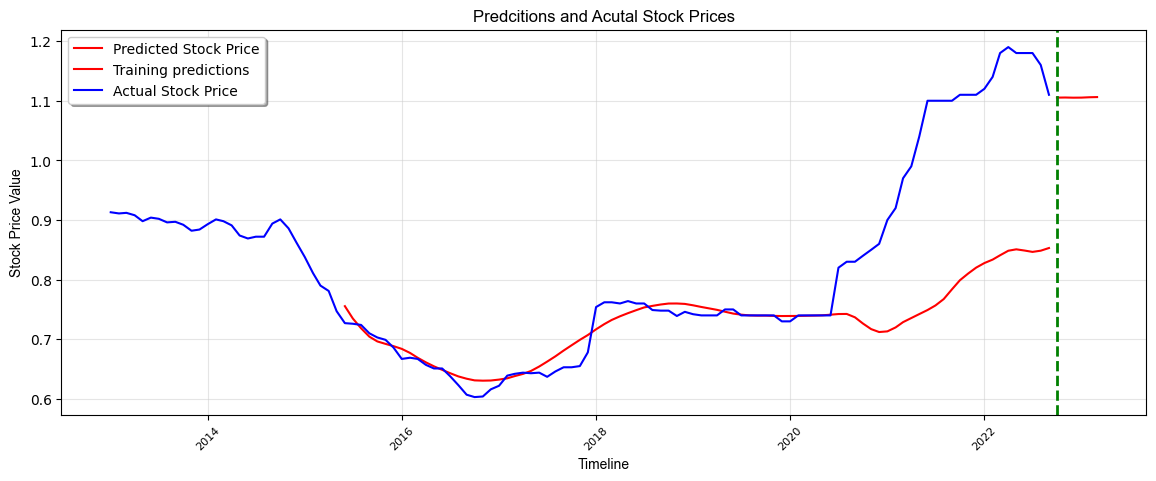

C:\Users\Administrator\AppData\Local\Temp\ipykernel_21612\1456007446.py:159: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final_res= df_final_res.append(PREDICTIONS_FUTURE)


In [98]:
x= (pipeline('أسلاك كهربائية 2.5مم وطني.xlsx'))


In [99]:
x

,price,predicted_training,predicted_forecast,element_name
2013-01-01,0.913,NaN,NaN,أسلاك كهربائية 2.5مم وطني
2013-02-01,0.911,NaN,NaN,أسلاك كهربائية 2.5مم وطني
2013-03-01,0.912,NaN,NaN,أسلاك كهربائية 2.5مم وطني
2013-04-01,0.908,NaN,NaN,أسلاك كهربائية 2.5مم وطني
2013-05-01,0.898,NaN,NaN,أسلاك كهربائية 2.5مم وطني
...,...,...,...,...
2022-11-01,NaN,NaN,1.105437,أسلاك كهربائية 2.5مم وطني
2022-12-01,NaN,NaN,1.105152,أسلاك كهربائية 2.5مم وطني
2023-01-01,NaN,NaN,1.105259,أسلاك كهربائية 2.5مم وطني
2023-02-01,NaN,NaN,1.105879,أسلاك كهربائية 2.5مم وطني


          date  price  oil_brent       tasi      gold  interest_rate  \
0   2013-01-01  0.913     114.54   7,043.55  1,662.00           0.14   
1   2013-02-01  0.911     110.42   6,998.33  1,578.90           0.15   
2   2013-03-01  0.912     109.79   7,125.73  1,595.70           0.14   
3   2013-04-01  0.908     102.04   7,179.80  1,472.70           0.15   
4   2013-05-01  0.898     100.20   7,404.12  1,393.00           0.11   
..         ...    ...        ...        ...       ...            ...   
112 2022-05-01  1.180     115.60  12,921.74  1,848.40           0.77   
113 2022-06-01  1.180     109.03  11,523.25  1,812.00           1.21   
114 2022-07-01  1.180     103.97  12,199.08  1,771.50           1.68   
115 2022-08-01  1.160      95.64  12,283.33  1,721.40           2.33   
116 2022-09-01  1.110      85.14  11,405.32  1,672.00           2.56   

     historical  
0      0.819371  
1      0.913000  
2      0.911000  
3      0.912000  
4      0.908000  
..          ...  
112    1.

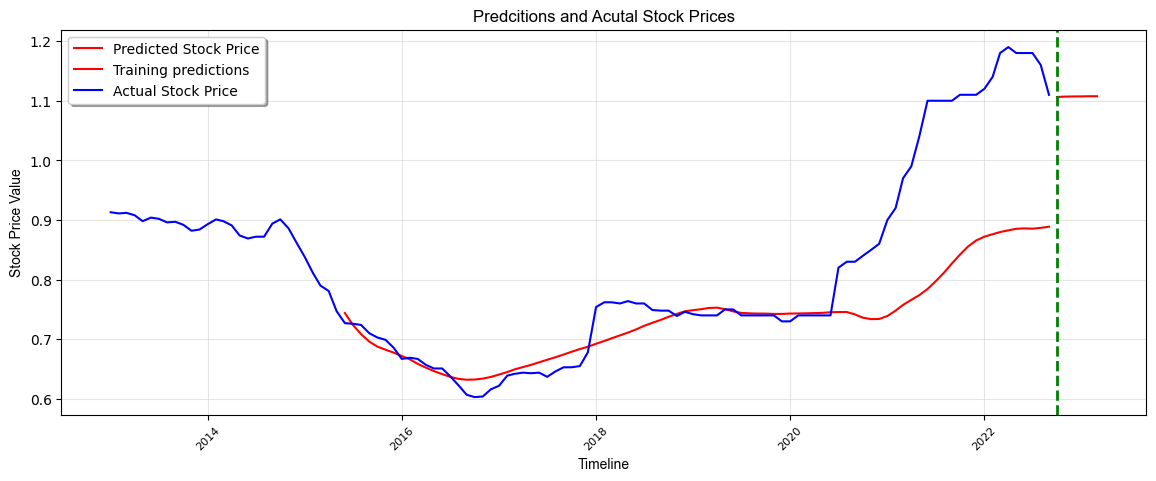

C:\Users\Administrator\AppData\Local\Temp\ipykernel_21612\566717415.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final_res= df_final_res.append(PREDICTIONS_FUTURE)


,price,predicted_training,predicted_forecast,element_name
2013-01-01,0.913,NaN,NaN,أسلاك كهربائية 2.5مم وطني
2013-02-01,0.911,NaN,NaN,أسلاك كهربائية 2.5مم وطني
2013-03-01,0.912,NaN,NaN,أسلاك كهربائية 2.5مم وطني
2013-04-01,0.908,NaN,NaN,أسلاك كهربائية 2.5مم وطني
2013-05-01,0.898,NaN,NaN,أسلاك كهربائية 2.5مم وطني
...,...,...,...,...
2022-11-01,NaN,NaN,1.106974,أسلاك كهربائية 2.5مم وطني
2022-12-01,NaN,NaN,1.107200,أسلاك كهربائية 2.5مم وطني
2023-01-01,NaN,NaN,1.107320,أسلاك كهربائية 2.5مم وطني
2023-02-01,NaN,NaN,1.107563,أسلاك كهربائية 2.5مم وطني


In [58]:
# ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| Data preprocessing
# import training dataset
filepath= r'C:\Users\fnafisa\WORKSPACE\professional\Project PoC\Input\data\Construction materials\segregated\أسلاك كهربائية 2.5مم وطني.xlsx'
dataset_train= pd.read_excel(filepath)
element_name= dataset_train.pop('element_name')[0]
dataset_train.columns = ['date','price', 'oil_brent', 'tasi', 'gold', 'interest_rate', 'historical']
dataset_train= dataset_train.sort_values(by=['date'], ascending=True)

# features selection
cols= list(dataset_train)[1:-1]


# Extract dates (timestamp format)
datelist_train = list(dataset_train['date'])


# dataset_train.index= dataset_train.pop('date')
print(dataset_train)
print('Training set shape == {}'.format(dataset_train.shape))
print('All timestamps == {}'.format(len(datelist_train)))
print('Featured selected: {}'.format(cols))
print('Sample of date list: {}...{}'.format(datelist_train[0:2], datelist_train[-3:-1]))
# |||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

# ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| Shaping and transformation
# dataset traing will be the essanse of all the upcoming datasets(training_set, training_set_scaled, X_train, y_train...)
# make sure there are no commas in any number                                                      "Target"      |--------------------"Predictors"-------------------|
dataset_train = dataset_train[cols].astype(str) # to remove the date and select only the features : ['price', 'oil_brent', 'tasi', 'gold', 'interest_rate', 'historical']
for i in cols:
    for j in range(0, len(dataset_train)):
        dataset_train[i][j] = dataset_train[i][j].replace(',', '')

dataset_train = dataset_train.astype(float)

# by using multiple predictors (features) we need to convert (reshape) to a matrix(array) using .to_numpy
training_set= dataset_train.to_numpy()



# Feature scaling hence features vary in range
sc = StandardScaler()
training_set_scaled = sc.fit_transform(training_set)

sc_predict = StandardScaler()
target_scaled= sc_predict.fit_transform(training_set[:, 0:1])



print('Shape of training set        == {}.'.format(training_set.shape))
print('Shape of training set scaled == {}.'.format(training_set_scaled.shape))
# |||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

# ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| Modeling
# Create a data structure with timestamps
# Target/features selection
X_train= []
y_train= []
n_future= 6 # number of moths to be predicted
n_past= 12 # the size of the windowed dataframe

for i in range(n_past, len(training_set_scaled) - n_future +1):
    X_train.append(training_set_scaled[i - n_past:i, 0:dataset_train.shape[1]])
    y_train.append(training_set_scaled[i + n_future - 1:i + n_future, 0])


X_train, y_train = np.array(X_train), np.array(y_train)

print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))
# |||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

# ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| Generate index
# Generate list of sequence of months for predictions w datetime type
datelist_future = pd.date_range(datelist_train[-1], periods=n_future, freq='1m').tolist()
datelist_future_= []
for d in datelist_future:
    d= d + dt.timedelta(days=1)
    d= d.date()
    datelist_future_.append(d)
datelist_future= datelist_future_
del datelist_future_

datelist_train_= []
for this_timestamp in datelist_train:
    datelist_train_.append(this_timestamp.date())
datelist_train= datelist_train_
del datelist_train_
# |||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

# ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| Build the model, and train & evaluate it
# build the model
model= Sequential()
model.add(LSTM(units=16, return_sequences=True, input_shape=(n_past, X_train.shape[-1])))
model.add(Dropout(.20))
model.add(LSTM(units=10, return_sequences=False))
model.add(Dropout(.30))
model.add(Dense(units=1, activation='linear'))
model.compile(optimizer= Adam(learning_rate=.0075), loss= 'mean_squared_error')

# %%time
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=20, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')

history = model.fit(X_train, y_train, shuffle=False, epochs=100, callbacks=[es, rlr, mcp, tb], validation_split=0.3, verbose=1, batch_size=32)
# |||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

# ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| Predict n_future
# Perform predictions
predictions_train = model.predict(X_train[n_past:])
predictions_future = model.predict(X_train[-n_future:])


y_pred_future = sc_predict.inverse_transform(predictions_future)
y_pred_train = sc_predict.inverse_transform(predictions_train)


# Prediction n_future
# allocate original data point and predicted data point
data_point_og, data_point_predicted= sc_predict.inverse_transform(target_scaled[-n_future:]), y_pred_future
# calculate the factor
factor= (data_point_og[-1] - data_point_predicted[-1]) / data_point_predicted[-1]

data_point_predicted_w_factor= (data_point_predicted * factor) + data_point_predicted
# data_point_predicted_w_factor= data_point_predicted

# Prediction
arr= np.array(data_point_predicted_w_factor)
for i in range(n_future):
    m= arr.mean()
    arr= np.append(arr, m)
    arr= np.delete(arr, 0)
data_point_predicted_w_factor= arr
# |||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

# ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| Visualization
training_start= 2 * n_past + n_future -1
PREDICTIONS_FUTURE = pd.DataFrame(data_point_predicted_w_factor, columns=['predicted_forecast']).set_index(pd.Series(datelist_future))
PREDICTION_TRAIN = pd.DataFrame(y_pred_train, columns=['predicted_training']).set_index(pd.Series(datelist_train[training_start:]))

dataset_train.index= datelist_train
# Set plot size 
from pylab import rcParams
rcParams['figure.figsize'] = 14, 5

# Plot parameters
START_DATE_FOR_PLOTTING = '2013-01-01'

plt.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE['predicted_forecast'], color='r', label='Predicted Stock Price')
plt.plot(PREDICTION_TRAIN.loc[:].index, PREDICTION_TRAIN.loc[:]['predicted_training'], color='r', label='Training predictions')
plt.plot(dataset_train.loc[:].index, dataset_train.loc[:]['price'], color='b', label='Actual Stock Price')

plt.axvline(x = min(PREDICTIONS_FUTURE.index), color='green', linewidth=2, linestyle='--')

plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.legend(shadow=True)
plt.title('Predcitions and Acutal Stock Prices', family='Arial', fontsize=12)
plt.xlabel('Timeline', family='Arial', fontsize=10)
plt.ylabel('Stock Price Value', family='Arial', fontsize=10)
plt.xticks(rotation=45, fontsize=8)
plt.show()
# |||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

# ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| final results
# final result to export
df_price= pd.DataFrame(dataset_train.loc[:]['price'])
df_price
df_final_res = pd.merge(df_price, PREDICTION_TRAIN, how='left', left_index=True, right_index=True)
df_final_res
df_final_res= df_final_res.append(PREDICTIONS_FUTURE)
df_final_res['element_name']= element_name
df_final_res

C:\Users\Administrator\AppData\Local\Temp\ipykernel_21612\567188419.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final_res= df_final_res.append(PREDICTIONS_FUTURE)


,price,predicted_training,predicted_forecast
2013-01-01,0.913,NaN,NaN
2013-02-01,0.911,NaN,NaN
2013-03-01,0.912,NaN,NaN
2013-04-01,0.908,NaN,NaN
2013-05-01,0.898,NaN,NaN
...,...,...,...
2022-11-01,NaN,NaN,1.103268
2022-12-01,NaN,NaN,1.104274
2023-01-01,NaN,NaN,1.104892
2023-02-01,NaN,NaN,1.105125
